# Embedding and categorizer tests



In [ ]:
%pip install - U pip setuptools wheel
%pip install tqdm
%pip install torch torchvision torchaudio
!export CUDA_PATH = "/opt/nvidia/cuda"
%pip install - U spacy[cuda11X, transformers]
%pip install transformers[sentencepiece]

In [1]:
!python3 -m spacy download en_core_web_lg -qq
!python3 -m spacy download en_core_web_trf -qq

2023-03-23 11:01:55.816882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 11:01:57.369844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 11:01:57.370214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 11:01:57.370365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [14]:
import json
from tqdm import tqdm
import spacy
from thinc.api import set_gpu_allocator, require_gpu
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, jaccard_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models
sns.set()
pyLDAvis.enable_notebook()

with open('selected_tags.json', 'r') as openfile:
    selected_tags = json.load(openfile)


In [2]:
sample_train = pd.read_csv(
    './train.csv', converters={'tag_set': eval, 'tag_list': eval})
sample_test = pd.read_csv(
    './test.csv', converters={'tag_set': eval, 'tag_list': eval})
sample_validation = pd.read_csv(
    './validation.csv', converters={'tag_set': eval, 'tag_list': eval})

sample_validation.text.fillna("", inplace=True)
sample_validation.code.fillna("", inplace=True)
sample_validation.tag_list = sample_validation.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])

mlb = MultiLabelBinarizer()
mlb.fit([selected_tags])
y = mlb.transform(sample_validation.tag_list.values)
y_sets = sample_validation.tag_list.apply(set)


In [11]:


# Use the GPU, with memory allocations directed via PyTorch.
# This prevents out-of-memory errors that would otherwise occur from competing
# memory pools.
set_gpu_allocator("pytorch")
require_gpu(0)


def preprocess(texts, nlp, return_tokens=False):
    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
               'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']

    results = []
    print("preprocessing")
    for summary in tqdm(nlp.pipe(texts, disable=["tok2vec"]), total=len(texts)):
        question_tokens = []
        for token in summary:
            if token.pos_ not in removal and not token.is_stop and token.is_alpha:
                question_tokens.append(token.lemma_)
        if return_tokens:
            results.append(question_tokens)
        else:
            results.append(" ".join(question_tokens))
    # question_tokens = [token.lemma_ for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    return results

def preprocess_transformers(texts):
    tokens = []
    removal = [ 'PUNCT', 'SPACE', 'NUM', 'SYM']
    cleaned_texts = []
    print("preprocessing")
    for summary in tqdm(nlp.pipe(texts, disable=["transformer", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]), total=len(texts)):
        question_tokens = []
        for token in summary:
            if token.pos_ not in removal and token.is_alpha and len(question_tokens)<512:
                question_tokens.append(token.lower_)
        cleaned_texts.append(" ".join(question_tokens))
    # question_tokens = [token.lemma_ for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    return cleaned_texts


def convert(data, outfile, nlp):
    db = spacy.tokens.DocBin()
    docs = []
    print("converting")
    for doc, labels in tqdm(nlp.pipe(data.values, as_tuples=True), total=len(data)):
        for tag in selected_tags:
            doc.cats[tag] = tag in labels
        db.add(doc)
    db.to_disk(outfile)

def evaluate_predictions(y_val, y_pred_text, y_pred_code, mlb, model_name):
    y_union = (y_pred_text.astype(np.bool_) |
               y_pred_code.astype(np.bool_)).astype(np.int_)

    y_intersec = (y_pred_text.astype(np.bool_) &
                y_pred_code.astype(np.bool_)).astype(np.int_)
    results = {
        "text": {
            "roc_per_tags": list(
                zip(mlb.classes_, roc_auc_score(y_val, y_pred_text, average=None))),
            "roc_macro": roc_auc_score(y_val, y_pred_text, average='macro'),
            "jaccard_samples": jaccard_score(y_val, y_pred_text, average='samples'),
            "jaccard_macro": jaccard_score(y_val, y_pred_text, average='macro'),
            "jaccard_micro": jaccard_score(y_val, y_pred_text, average='micro'),
            "f1_samples": f1_score(y_val, y_pred_text, average='samples'),
            "f1_macro": f1_score(y_val, y_pred_text, average='macro'),
            "f1_micro": f1_score(y_val, y_pred_text, average='micro'),
            "precision_samples": precision_score(y_val, y_pred_text, average='samples'),
            "precision_macro": precision_score(y_val, y_pred_text, average='macro'),
            "precision_micro": precision_score(y_val, y_pred_text, average='micro'),
            "recall_samples": recall_score(y_val, y_pred_text, average='samples'),
            "recall_macro": recall_score(y_val, y_pred_text, average='macro'),
            "recall_micro": recall_score(y_val, y_pred_text, average='micro'),
        },
        "code": {
            "roc_per_tags": list(zip(mlb.classes_, roc_auc_score(y_val, y_pred_code, average=None))),
            "roc_macro": roc_auc_score(y_val, y_pred_code, average='macro'),
            "jaccard_samples": jaccard_score(y_val, y_pred_code, average='samples'),
            "jaccard_macro": jaccard_score(y_val, y_pred_code, average='macro'),
            "jaccard_micro": jaccard_score(y_val, y_pred_code, average='micro'),
            "f1_samples": f1_score(y_val, y_pred_code, average='samples'),
            "f1_macro": f1_score(y_val, y_pred_code, average='macro'),
            "f1_micro": f1_score(y_val, y_pred_code, average='micro'),
            "precision_samples": precision_score(y_val, y_pred_code, average='samples'),
            "precision_macro": precision_score(y_val, y_pred_code, average='macro'),
            "precision_micro": precision_score(y_val, y_pred_code, average='micro'),
            "recall_samples": recall_score(y_val, y_pred_code, average='samples'),
            "recall_macro": recall_score(y_val, y_pred_code, average='macro'),
            "recall_micro": recall_score(y_val, y_pred_code, average='micro'),
        },
        "union": {
            "roc_per_tags": list(zip(mlb.classes_, roc_auc_score(y_val, y_union, average=None))),
            "roc_macro": roc_auc_score(y_val, y_union, average='macro'),
            "jaccard_samples": jaccard_score(y_val, y_union, average='samples'),
            "jaccard_macro": jaccard_score(y_val, y_union, average='macro'),
            "jaccard_micro": jaccard_score(y_val, y_union, average='micro'),
            "f1_samples": f1_score(y_val, y_union, average='samples'),
            "f1_macro": f1_score(y_val, y_union, average='macro'),
            "f1_micro": f1_score(y_val, y_union, average='micro'),
            "precision_samples": precision_score(y_val, y_union, average='samples'),
            "precision_macro": precision_score(y_val, y_union, average='macro'),
            "precision_micro": precision_score(y_val, y_union, average='micro'),
            "recall_samples": recall_score(y_val, y_union, average='samples'),
            "recall_macro": recall_score(y_val, y_union, average='macro'),
            "recall_micro": recall_score(y_val, y_union, average='micro'),
        },
        "intersection": {
            "roc_per_tags": list(zip(mlb.classes_, roc_auc_score(y_val, y_intersec, average=None))),
            "roc_macro": roc_auc_score(y_val, y_intersec, average='macro'),
            "jaccard_samples": jaccard_score(y_val, y_intersec, average='samples'),
            "jaccard_macro": jaccard_score(y_val, y_intersec, average='macro'),
            "jaccard_micro": jaccard_score(y_val, y_intersec, average='micro'),
            "f1_samples": f1_score(y_val, y_intersec, average='samples'),
            "f1_macro": f1_score(y_val, y_intersec, average='macro'),
            "f1_micro": f1_score(y_val, y_intersec, average='micro'),
            "precision_samples": precision_score(y_val, y_intersec, average='samples'),
            "precision_macro": precision_score(y_val, y_intersec, average='macro'),
            "precision_micro": precision_score(y_val, y_intersec, average='micro'),
            "recall_samples": recall_score(y_val, y_intersec, average='samples'),
            "recall_macro": recall_score(y_val, y_intersec, average='macro'),
            "recall_micro": recall_score(y_val, y_intersec, average='micro'),
        },
    }

    for i in ["text", "code", "union", "intersection"]:
        print(f"======= {i} ==========")
        print("Roc auc for each tag:")
        print(results[i]["roc_per_tags"])
        print(f"Roc auc macro average: {results[i]['roc_macro']:.3f}")
        print(
            f"Jaccard score sample average: {results[i]['jaccard_samples']:.3f}")
        print(
            f"Jaccard score macro average: {results[i]['jaccard_macro']:.3f}")
        print(
            f"Jaccard score micro average: {results[i]['jaccard_micro']:.3f}")
        print(
            f"f1 score sample average: {results[i]['f1_samples']:.3f}")
        print(
            f"f1 score macro average: {results[i]['f1_macro']:.3f}")
        print(
            f"f1 score micro average: {results[i]['f1_micro']:.3f}")
        print(
            f"precision score sample average: {results[i]['precision_samples']:.3f}")
        print(
            f"precision score macro average: {results[i]['precision_macro']:.3f}")
        print(
            f"precision score micro average: {results[i]['precision_micro']:.3f}")
        print(
            f"recall score sample average: {results[i]['recall_samples']:.3f}")
        print(
            f"recall score macro average: {results[i]['recall_macro']:.3f}")
        print(
            f"recall score micro average: {results[i]['recall_micro']:.3f}")

    with open(f"{model_name}_results.json", "w") as outfile:
        json.dump(results, outfile)


## Unsupervised method - Latent Dirichlet Association

In [4]:
train_df = sample_train.loc[:]
for tag in selected_tags:
    train_df[tag] = train_df.tag_set.apply(
        lambda x: 1 if tag in x else 0)

train_df


,Title,Body,Tags,Score,ViewCount,AnswerCount,nbtags,tag_set,tag_list,text,...,iphone,javascript,c#,c++,php,.net,css,java,html,python
0,Publish/Subscribe reliable messaging: Redis VS...,<h2>Background</h2>\n\n<p>I am making a publis...,<javascript><node.js><redis><rabbitmq><publish...,25,16250,3,5,"{redis, publish-subscribe, javascript, node.js...","[javascript, node.js, redis, rabbitmq, publish...",Background\n\n\nI am making a publish/subscrib...,...,0,1,0,0,0,0,0,0,0,0
1,What is an undefined reference/unresolved exte...,<p>What are undefined reference/unresolved ext...,<c++><linker-errors><undefined-reference><c++-...,1757,871034,39,5,"{unresolved-external, undefined-reference, c++...","[c++, linker-errors, undefined-reference, c++-...",What are undefined reference/unresolved extern...,...,0,0,0,1,0,0,0,0,0,0
2,How MediaCodec finds the codec inside the fram...,<p>I am trying to understanding how MediaCodec...,<android><android-internet><stagefright><openm...,7,4538,1,5,"{android, opencore, openmax, android-internet,...","[android, android-internet, stagefright, openm...",I am trying to understanding how MediaCodec is...,...,0,0,0,0,0,0,0,0,0,0
3,Can I just inject super class when use dagger2...,<p>I use Dagger2 for DI in my android applicat...,<java><android><dependency-injection><dagger><...,51,23085,3,5,"{dagger-2, dependency-injection, android, java...","[java, android, dependency-injection, dagger, ...",I use Dagger2 for DI in my android application...,...,0,0,0,0,0,0,0,1,0,0
4,NetworkSecurityConfig: No Network Security Con...,<p>I have some problem for android 7.0.0.</p>\...,<java><android><android-studio><android-volley>,10,30564,3,4,"{android-studio, java, android, android-volley}","[java, android, android-studio, android-volley]",I have some problem for android 7.0.0.\n\n\nI ...,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105710,Fill image inside with color in fabric.js,"<p>Basically, I have a png transparent image a...",<javascript><jquery><css><canvas><fabricjs>,8,2873,1,5,"{fabricjs, jquery, javascript, css, canvas}","[javascript, jquery, css, canvas, fabricjs]","Basically, I have a png transparent image and ...",...,0,1,0,0,0,0,1,0,0,0
105711,jquery-ui sortable getting error - PUT 501 (No...,<p>I have a Rails app with jquery-ui sortable ...,<jquery><ruby-on-rails><apache><jquery-ui>,10,1275,5,4,"{apache, jquery-ui, jquery, ruby-on-rails}","[jquery, ruby-on-rails, apache, jquery-ui]",I have a Rails app with jquery-ui sortable lis...,...,0,0,0,0,0,0,0,0,0,0
105712,UnicodeEncodeError: 'ascii' codec can't encode...,<p>I'm trying to print a string from an <a hre...,<python><unicode><character-encoding><web-scra...,9,14333,1,4,"{web-scraping, python, character-encoding, uni...","[python, unicode, character-encoding, web-scra...",I'm trying to print a string from an \narchive...,...,0,0,0,0,0,0,0,0,0,1
105713,How can I rotate a UIImageView with respect to...,"<p>By default, a UIImageView will rotate only ...",<iphone><cocoa-touch><uikit><core-animation>,10,17594,1,4,"{core-animation, uikit, cocoa-touch, iphone}","[iphone, cocoa-touch, uikit, core-animation]","By default, a UIImageView will rotate only abo...",...,1,0,0,0,0,0,0,0,0,0


In [13]:
train_df.fillna('', inplace=True)
nlp = spacy.load('en_core_web_lg')
train_df["tokens"] = preprocess(train_df.text, nlp, return_tokens=True)

preprocessing


100%|██████████| 105715/105715 [10:46<00:00, 163.41it/s]


### Text

In [16]:
text_dictionary = Dictionary(train_df['tokens'])
text_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
text_corpus = [text_dictionary.doc2bow(doc)
               for doc in tqdm(train_df['tokens'])]

100%|██████████| 105715/105715 [00:05<00:00, 20952.09it/s]


In [18]:
topics = range(3, 21)
c_umass_score = []
c_v_score = []
for i in tqdm(topics):
   lda_model = LdaMulticore(corpus=text_corpus, id2word=text_dictionary, iterations=10,
                            num_topics=i,  passes=10, random_state=100)
   c_umass = CoherenceModel(model=lda_model, corpus=text_corpus,
                            dictionary=text_dictionary, coherence='u_mass')
   c_v = CoherenceModel(model=lda_model, corpus=text_corpus, texts=train_df['tokens'],
                        dictionary=text_dictionary, coherence='c_v')
   c_umass_score.append(c_umass.get_coherence())
   c_v_score.append(c_v.get_coherence())



100%|██████████| 18/18 [33:24<00:00, 111.38s/it]


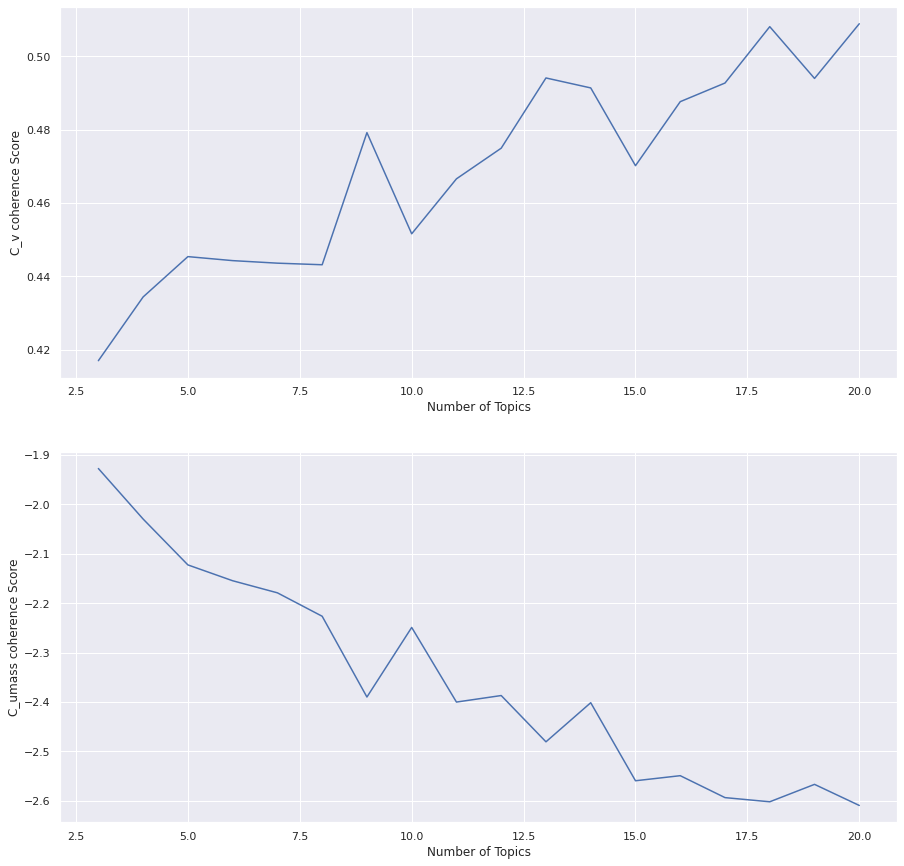

In [19]:
f, axes = plt.subplots(2, 1, figsize=(15, 15))
axes[0].plot(topics, c_v_score)
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('C_v coherence Score')
axes[1].plot(topics, c_umass_score)
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('C_umass coherence Score')
plt.show()


In [21]:
lda_model = LdaMulticore(corpus=text_corpus, id2word=text_dictionary,
                         iterations=100, num_topics=14,  passes=100)

In [22]:
lda_model.print_topics(-1)

[(0,
  '0.043*"data" + 0.034*"array" + 0.033*"string" + 0.033*"value" + 0.028*"memory" + 0.022*"values" + 0.021*"object" + 0.018*"like" + 0.015*"function" + 0.015*"want"'),
 (1,
  '0.037*"element" + 0.035*"table" + 0.024*"div" + 0.021*"elements" + 0.020*"want" + 0.020*"list" + 0.020*"like" + 0.019*"scroll" + 0.019*"height" + 0.017*"width"'),
 (2,
  '0.124*"app" + 0.050*"android" + 0.046*"ios" + 0.028*"iphone" + 0.027*"device" + 0.023*"xcode" + 0.017*"application" + 0.013*"apple" + 0.012*"devices" + 0.012*"apps"'),
 (3,
  '0.039*"code" + 0.039*"problem" + 0.038*"tried" + 0.035*"works" + 0.034*"work" + 0.027*"fine" + 0.025*"issue" + 0.022*"working" + 0.015*"update" + 0.014*"help"'),
 (4,
  '0.046*"server" + 0.032*"data" + 0.026*"user" + 0.025*"request" + 0.024*"database" + 0.022*"client" + 0.019*"api" + 0.018*"service" + 0.016*"application" + 0.015*"web"'),
 (5,
  '0.083*"page" + 0.049*"html" + 0.046*"javascript" + 0.040*"jquery" + 0.033*"css" + 0.031*"browser" + 0.024*"chrome" + 0.020*"

In [23]:
train_df.iloc[0].text


"Background\n\n\nI am making a publish/subscribe typical application where a publisher sends messages to a consumer. \n\n\nThe publisher and the consumer are on different machines and the connection between them can break occasionally. \n\n\nObjective\n\n\nThe goal here is to make sure that no matter what happens to the connection, or to the machines themselves, a message sent by a publisher is \nalways\n received by the \nconsumer\n. \n\n\nOrdering of messages is not a must.\n\n\nProblem\n\n\nAccording to my research, RabbitMQ is the right choice for this scenario:\n\n\n\n\nRedis Vs RabbitMQ as a data broker/messaging system in between Logstash and elasticsearch\n\n\n\n\nHowever, although RabbitMQ has a tutorial about \npublish and subscriber\n this tutorial does not present us to persistent queues nor does it mention \nconfirms\n which I believe are the key to making sure messages are delivered.\n\n\nOn the other hand, Redis is also capable of doing this:\n\n\n\n\nhttp://abhinavsingh

In [24]:
lda_model[text_corpus][0]

[(0, 0.034307692),
 (4, 0.21334669),
 (7, 0.11552945),
 (9, 0.565641),
 (10, 0.030141188),
 (11, 0.031007634)]

In [25]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, text_corpus, text_dictionary)
pyLDAvis.display(lda_display)


/home/aurelien/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/aurelien/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
5169.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5170.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5170.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5170.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5170.80s - pydevd: Sending message related to process being replaced timed-out

In [26]:
train_df['text_topic'] = [sorted(lda_model[text_corpus][text])[0][0]
                      for text in range(len(train_df.text))]


5173.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5173.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


<AxesSubplot:>

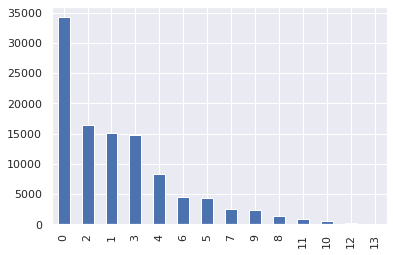

In [27]:
train_df.text_topic.value_counts().plot.bar()


<AxesSubplot:>

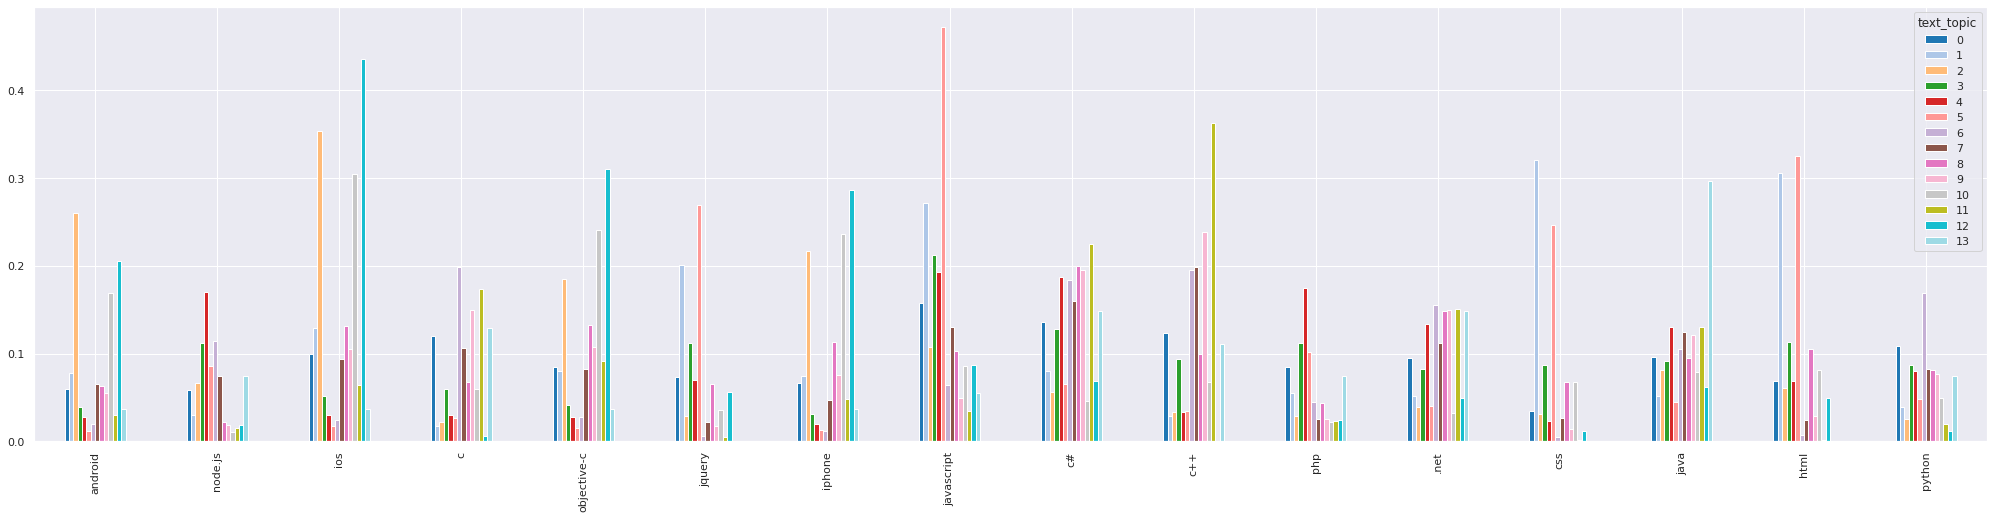

In [33]:
train_df.groupby(
    "text_topic")[list(selected_tags)].mean().transpose().plot.bar(figsize=(35, 8), cmap='tab20')


In [39]:
tag_means = train_df.groupby(
    "text_topic")[list(selected_tags)].mean().transpose()
text_topic_tags = {}
for i in range(14):
    text_topic_tags[i] = tag_means.loc[tag_means[i]>0.15].index.to_list()
text_topic_tags


{0: ['javascript'],
 1: ['jquery', 'javascript', 'css', 'html'],
 2: ['android', 'ios', 'objective-c', 'iphone'],
 3: ['javascript'],
 4: ['node.js', 'javascript', 'c#', 'php'],
 5: ['jquery', 'javascript', 'css', 'html'],
 6: ['c', 'c#', 'c++', '.net', 'python'],
 7: ['c#', 'c++'],
 8: ['c#'],
 9: ['c#', 'c++', '.net'],
 10: ['android', 'ios', 'objective-c', 'iphone'],
 11: ['c', 'c#', 'c++', '.net'],
 12: ['android', 'ios', 'objective-c', 'iphone'],
 13: ['java']}

### Code

preprocessing


100%|██████████| 18/18 [17:46<00:00, 59.26s/it]


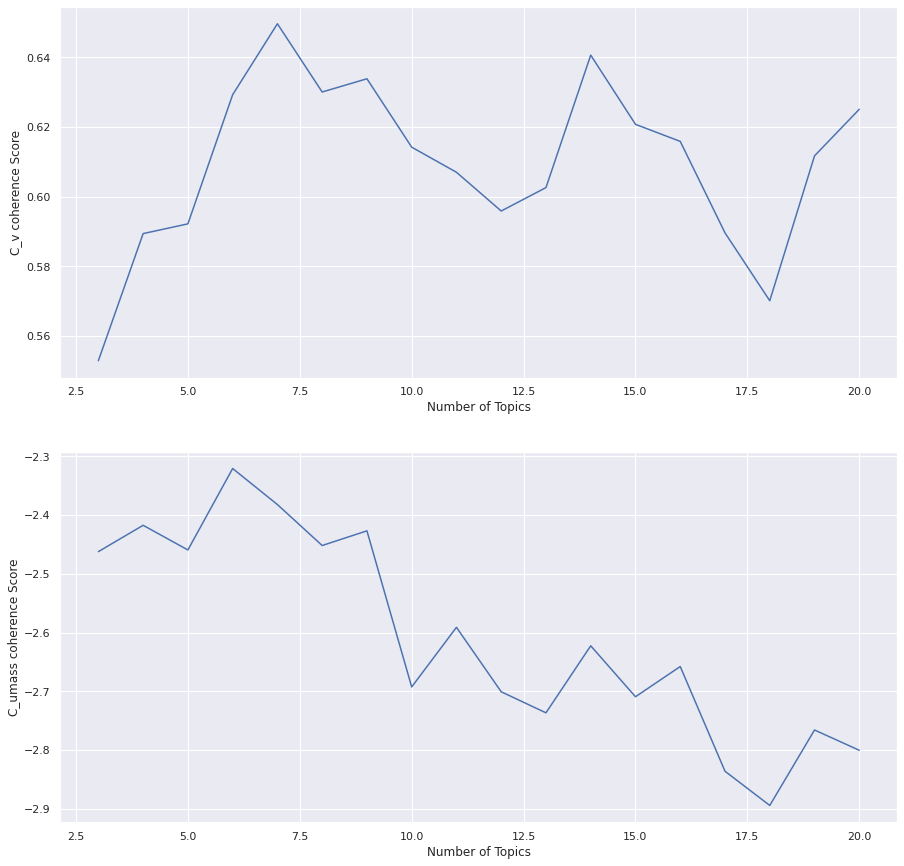

In [53]:
train_df["code_tokens"] = preprocess(train_df.code, nlp, return_tokens=True)
code_dictionary = Dictionary(train_df['code_tokens'])
code_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
code_corpus = [code_dictionary.doc2bow(doc)
               for doc in tqdm(train_df['code_tokens'])]

topics = range(3, 21)
c_umass_score = []
c_v_score = []
for i in tqdm(topics):
   code_lda_model = LdaMulticore(corpus=code_corpus, id2word=code_dictionary, iterations=10,
                            num_topics=i,  passes=10, random_state=100)
   c_umass = CoherenceModel(model=code_lda_model, corpus=code_corpus,
                            dictionary=code_dictionary, coherence='u_mass')
   c_v = CoherenceModel(model=code_lda_model, corpus=code_corpus, texts=train_df['code_tokens'],
                        dictionary=code_dictionary, coherence='c_v')
   c_umass_score.append(c_umass.get_coherence())
   c_v_score.append(c_v.get_coherence())


f, axes = plt.subplots(2, 1, figsize=(15, 15))
axes[0].plot(topics, c_v_score)
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('C_v coherence Score')
axes[1].plot(topics, c_umass_score)
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('C_umass coherence Score')
plt.show()


In [54]:
code_lda_model = LdaMulticore(corpus=code_corpus, id2word=code_dictionary,
                         iterations=100, num_topics=9,  passes=100)

In [55]:
train_df['code_topic'] = [sorted(code_lda_model[code_corpus][code])[0][0]
                      for code in range(len(train_df.code))]


<AxesSubplot:>

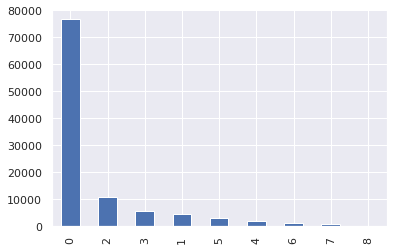

In [56]:
train_df.code_topic.value_counts().plot.bar()


<AxesSubplot:>

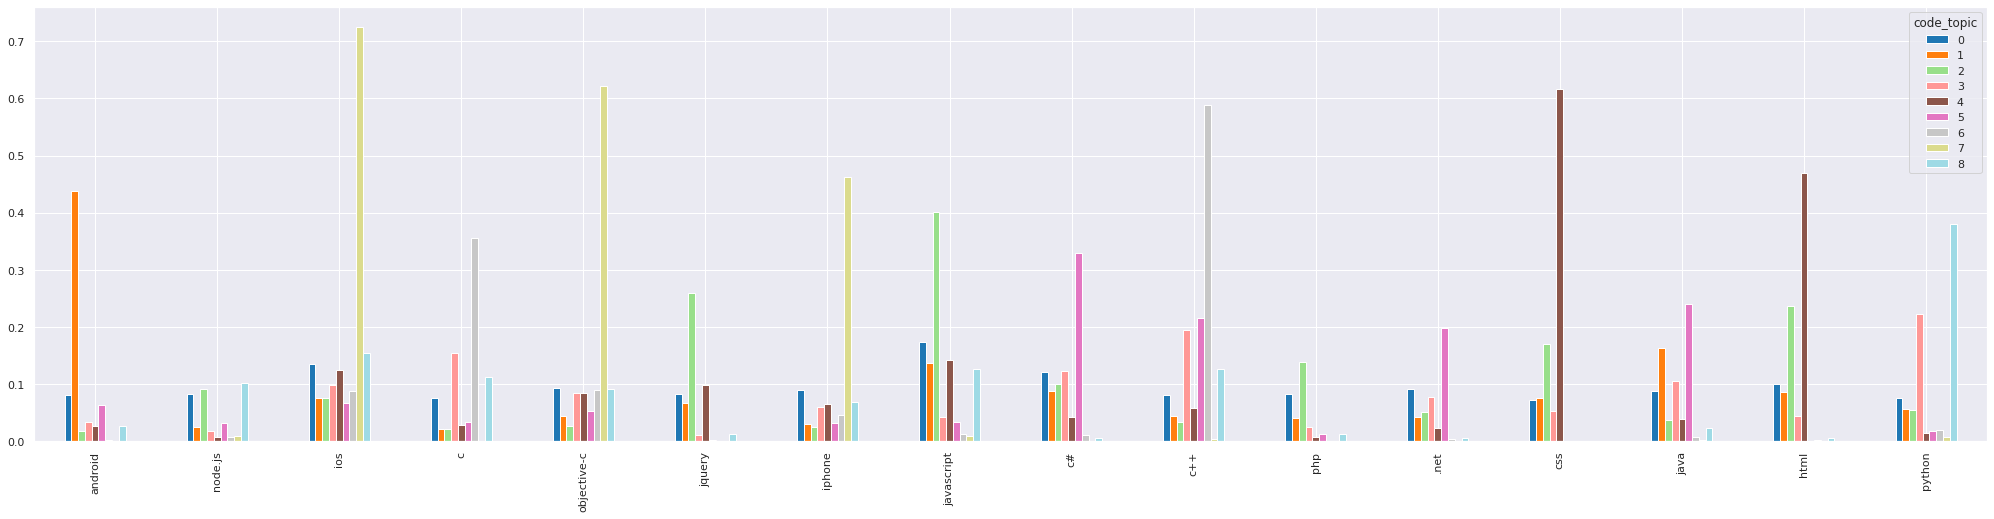

In [57]:
train_df.groupby(
    "code_topic")[list(selected_tags)].mean().transpose().plot.bar(figsize=(35, 8), cmap='tab20')


In [59]:
tag_means = train_df.groupby(
    "code_topic")[list(selected_tags)].mean().transpose()
code_topic_tags = {}
for i in range(9):
    code_topic_tags[i] = tag_means.loc[tag_means[i] > 0.15].index.to_list()
code_topic_tags


{0: ['javascript'],
 1: ['android', 'java'],
 2: ['jquery', 'javascript', 'css', 'html'],
 3: ['c', 'c++', 'python'],
 4: ['css', 'html'],
 5: ['c#', 'c++', '.net', 'java'],
 6: ['c', 'c++'],
 7: ['ios', 'objective-c', 'iphone'],
 8: ['ios', 'python']}

### Evaluation

In [61]:
val_df = sample_validation.loc[:]
val_df["text_tokens"] = preprocess(val_df.text, nlp, return_tokens=True)
val_df['code_tokens'] = preprocess(val_df.code, nlp, return_tokens=True)


preprocessing


100%|██████████| 14152/14152 [01:25<00:00, 166.17it/s]


preprocessing


100%|██████████| 14152/14152 [01:43<00:00, 136.44it/s]


In [62]:
text_val_corpus = [text_dictionary.doc2bow(doc)
                                for doc in tqdm(val_df["text_tokens"])]
val_df['text_topic'] = [sorted(lda_model[text_val_corpus][text])[0][0]
                        for text in range(len(val_df.text))]
code_val_corpus = [code_dictionary.doc2bow(doc)
                   for doc in tqdm(val_df["code_tokens"])]
val_df['code_topic'] = [sorted(code_lda_model[code_val_corpus][code])[0][0]
                        for code in range(len(val_df.code))]


100%|██████████| 14152/14152 [00:00<00:00, 38519.93it/s]


In [63]:
y_pred_text = val_df['text_topic'].apply(
    lambda x: text_topic_tags[x])
y_pred_code = val_df['code_topic'].apply(
    lambda x: code_topic_tags[x])


In [64]:
evaluate_predictions(y, mlb.transform(y_pred_text),
                     mlb.transform(y_pred_code), mlb, "lda")


/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.5320487579910052), ('android', 0.685507423277806), ('c', 0.5401222274973634), ('c#', 0.5456719697559057), ('c++', 0.5865815967338499), ('css', 0.7489242399681694), ('html', 0.6783100260087346), ('ios', 0.6622567445423352), ('iphone', 0.6521414471862699), ('java', 0.5017453410427498), ('javascript', 0.5787864304443942), ('jquery', 0.6335786921791717), ('node.js', 0.5678414551104376), ('objective-c', 0.6063024376364902), ('php', 0.548304911148666), ('python', 0.5295456761905566)]
Roc auc macro average: 0.600
Jaccard score sample average: 0.165
Jaccard score macro average: 0.143
Jaccard score micro average: 0.163
f1 score sample average: 0.222
f1 score macro average: 0.244
f1 score micro average: 0.281
precision score sample average: 0.203
precision score macro average: 0.242
precision score micro average: 0.225
recall score sample average: 0.336
recall score macro average: 0.338
recall score micro average: 0.373
======= code =====

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Supervised methods

### BOW with Spacy

In [ ]:
nlp = spacy.load('en_core_web_lg')

#### Text

In [ ]:
train_df = sample_train[~sample_train.text.isna()].loc[:]
train_df["text_processed"] = preprocess(train_df.text, nlp)
convert(train_df.loc[:, ["text_processed", "tag_list"]],
        'text_train_bow.spacy', nlp)
test_df = sample_test[~sample_test.text.isna()].loc[:]
test_df["text_processed"] = preprocess(test_df.text, nlp)
convert(test_df.loc[:, ["text_processed", "tag_list"]],
        'text_test_bow.spacy', nlp)
validation_df = sample_validation[~sample_validation.text.isna()].loc[:]
validation_df["text_processed"] = preprocess(
    validation_df.text, nlp)
convert(validation_df.loc[:, ["text_processed", "tag_list"]],
        'text_validation_bow.spacy', nlp)


preprocessing


  0%|          | 0/105710 [00:00<?, ?it/s]

converting


  0%|          | 0/105710 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/21648 [00:00<?, ?it/s]

converting


  0%|          | 0/21648 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/14149 [00:00<?, ?it/s]

converting


  0%|          | 0/14149 [00:00<?, ?it/s]

In [ ]:
!python3 -m spacy train config_BOW.cfg --output ./output_BOW --paths.train ./text_train_bow.spacy --paths.dev ./text_test_bow.spacy --gpu-id 0

2023-03-17 12:18:13.716779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 12:18:15.191947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 12:18:15.192320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 12:18:15.192476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Code

In [ ]:
train_df = sample_train[~sample_train.code.isna()].loc[:]
train_df["code_processed"] = preprocess(train_df.code, nlp)
convert(train_df.loc[:, ["code_processed", "tag_list"]],
        'code_train_bow.spacy', nlp)
test_df = sample_test[~sample_test.code.isna()].loc[:]
test_df["code_processed"] = preprocess(test_df.code, nlp)
convert(test_df.loc[:, ["code_processed", "tag_list"]],
        'code_test_bow.spacy', nlp)
validation_df = sample_validation[~sample_validation.code.isna()].loc[:]
validation_df["code_processed"] = preprocess(
    validation_df.code, nlp)
convert(validation_df.loc[:, ["code_processed", "tag_list"]],
        'code_validation_bow.spacy', nlp)


preprocessing


  0%|          | 0/81619 [00:00<?, ?it/s]

converting


  0%|          | 0/81619 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/16800 [00:00<?, ?it/s]

converting


  0%|          | 0/16800 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/10956 [00:00<?, ?it/s]

converting


  0%|          | 0/10956 [00:00<?, ?it/s]

In [ ]:
!python3 -m spacy train config_BOW.cfg --output ./output_code_BOW --paths.train ./code_train_bow.spacy --paths.dev ./code_test_bow.spacy --gpu-id 0

2023-03-17 13:35:08.530678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:35:10.172390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:35:10.172770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:35:10.172917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Evaluation

In [ ]:

nlp_lg = spacy.load('en_core_web_lg')
val_bow = sample_validation.loc[:]
val_bow["texts_processed"] = preprocess(val_bow.text, nlp_lg)
val_bow['codes_processed'] = preprocess(val_bow.code, nlp_lg)

nlp_text = spacy.load("./output_BOW/model-best")
nlp_code = spacy.load("./output_code_BOW/model-best")
text_cats = []
code_cats = []
for summary in tqdm(nlp_text.pipe(val_bow["texts_processed"].values), total=len(val_bow)):
    text_cats.append(summary.cats)

for summary in tqdm(nlp_code.pipe(val_bow["codes_processed"].values), total=len(val_bow)):
    code_cats.append(summary.cats)

val_bow["text_cats"] = text_cats
val_bow[val_bow.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
val_bow["code_cats"] = code_cats
val_bow[val_bow.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


preprocessing


100%|██████████| 14152/14152 [01:16<00:00, 185.89it/s]


preprocessing


100%|██████████| 14152/14152 [00:06<00:00, 2323.80it/s]
/tmp/ipykernel_5298/610484677.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_bow[val_bow.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
/tmp/ipykernel_5298/610484677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_bow[val_bow.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


In [ ]:
THRESHOLD = 0.5
y_pred_text = [[x for x in selected_tags if y[x] > THRESHOLD]
               for y in val_bow.text_cats.values]
y_pred_code = [[x for x in selected_tags if y[x] > THRESHOLD]
               for y in val_bow.code_cats.values]

y_pred_text = mlb.transform(y_pred_text)
y_pred_code = mlb.transform(y_pred_code)

evaluate_predictions(y, y_pred_text, y_pred_code, mlb, "bow")

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.6488900967782152), ('android', 0.8301444824905723), ('c', 0.7419467792574461), ('c#', 0.7319272956228179), ('c++', 0.7019025172772958), ('css', 0.8399595601095461), ('html', 0.736338138683504), ('ios', 0.7948700679334377), ('iphone', 0.6635471627376747), ('java', 0.7256070039936248), ('javascript', 0.744058014673224), ('jquery', 0.7819770185228876), ('node.js', 0.776855033231991), ('objective-c', 0.646231952979652), ('php', 0.7956970717251355), ('python', 0.8240978956325864)]
Roc auc macro average: 0.749
Jaccard score sample average: 0.482
Jaccard score macro average: 0.456
Jaccard score micro average: 0.451
f1 score sample average: 0.529
f1 score macro average: 0.617
f1 score micro average: 0.622
precision score sample average: 0.566
precision score macro average: 0.784
precision score micro average: 0.784
recall score sample average: 0.537
recall score macro average: 0.513
recall score micro average: 0.515
======= code =======

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tok2Vec with spacy

#### Text

In [ ]:
!python3 -m spacy train config_tok2vec.cfg --output ./output_tok2vec --paths.train ./text_train_bow.spacy --paths.dev ./text_test_bow.spacy --gpu-id 0

2023-03-17 12:20:20.144707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 12:20:21.668324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 12:20:21.671812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 12:20:21.671976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Code

In [ ]:
!python3 -m spacy train config_tok2vec.cfg --output ./output_code_tok2vec --paths.train ./code_train_bow.spacy --paths.dev ./code_test_bow.spacy --gpu-id 0

2023-03-17 13:34:36.026104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:34:37.612346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:34:37.612711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:34:37.612871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Evaluation

In [ ]:
val_tok2vec = val_bow.loc[:]
nlp_text = spacy.load("./output_tok2vec/model-best")
nlp_code = spacy.load("./output_code_tok2vec/model-best")
text_cats = []
code_cats = []
for summary in tqdm(nlp_text.pipe(val_tok2vec["texts_processed"].values), total=len(val_tok2vec)):
    text_cats.append(summary.cats)

for summary in tqdm(nlp_code.pipe(val_tok2vec["codes_processed"].values), total=len(val_tok2vec)):
    code_cats.append(summary.cats)

val_tok2vec["text_cats"] = text_cats
val_tok2vec[val_tok2vec.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
val_tok2vec["code_cats"] = code_cats
val_tok2vec[val_tok2vec.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


100%|██████████| 14152/14152 [00:07<00:00, 2010.20it/s]
/tmp/ipykernel_5298/308916592.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_tok2vec[val_tok2vec.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
/tmp/ipykernel_5298/308916592.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_tok2vec[val_tok2vec.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


In [ ]:
THRESHOLD = 0.5
y_pred_text = [[x for x in selected_tags if y[x] > THRESHOLD]
               for y in val_tok2vec.text_cats.values]
y_pred_code = [[x for x in selected_tags if y[x] > THRESHOLD]
               for y in val_tok2vec.code_cats.values]

y_pred_text = mlb.transform(y_pred_text)
y_pred_code = mlb.transform(y_pred_code)

evaluate_predictions(y, y_pred_text, y_pred_code, mlb, "tok2vec")


/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.6421738546586514), ('android', 0.8807337192195761), ('c', 0.7965499808922081), ('c#', 0.7380627650712426), ('c++', 0.718745238765006), ('css', 0.8528525867491494), ('html', 0.792017609560249), ('ios', 0.7830064177346702), ('iphone', 0.665392220285253), ('java', 0.771801953182504), ('javascript', 0.8119293888438004), ('jquery', 0.832020834035505), ('node.js', 0.8196238383189313), ('objective-c', 0.6038419139093959), ('php', 0.8302391235253427), ('python', 0.8801803381366468)]
Roc auc macro average: 0.776
Jaccard score sample average: 0.533
Jaccard score macro average: 0.486
Jaccard score micro average: 0.483
f1 score sample average: 0.585
f1 score macro average: 0.641
f1 score micro average: 0.652
precision score sample average: 0.613
precision score macro average: 0.754
precision score micro average: 0.744
recall score sample average: 0.605
recall score macro average: 0.574
recall score micro average: 0.580
======= code ========

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RoBertA with spacy


In [7]:
nlp = spacy.load("en_core_web_trf")

loading configuration file /tmp/tmp0lge8o9t/config.json
Model config RobertaConfig {
  "_name_or_path": "/tmp/tmp0lge8o9t/config.json",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json



#### Text

In [ ]:
train_df = sample_train[~sample_train.text.isna()].loc[:]
train_df["text_processed"] = preprocess_transformers(train_df.text, nlp)
test_df = sample_test[~sample_test.text.isna()].sample(
    round(len(sample_test)/4))
test_df["text_processed"] = preprocess_transformers(
    test_df.text, nlp)
validation_df = sample_validation[~sample_validation.text.isna()].loc[:]
validation_df["text_processed"] = preprocess_transformers(
    validation_df.text, nlp)
convert(train_df.loc[:, ["text_processed", "tag_list"]],
        'text_train_transformer.spacy', nlp)
convert(test_df.loc[:, ["text_processed",
        "tag_list"]], 'text_test_transformer.spacy', nlp)
convert(validation_df.loc[:, [
        "text_processed", "tag_list"]], 'text_validation_transformer.spacy', nlp)


preprocessing


100%|██████████| 5322/5322 [01:00<00:00, 87.44it/s] 


In [ ]:
!python3 -m spacy train config_transformer_filled.cfg --output ./output_transformer --paths.train ./text_train_transformer.spacy --paths.dev ./text_test_transformer.spacy --gpu-id 0

2023-03-16 16:03:36.530246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:03:38.978276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:03:38.978632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:03:38.978786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Code

In [ ]:
train_df = sample_train[~sample_train.code.isna()].loc[:]
train_df["code_processed"] = preprocess_transformers(train_df.code, nlp)
test_df = sample_test[~sample_test.code.isna()].sample(
    round(len(sample_test)/4))
test_df["code_processed"] = preprocess(test_df.code, nlp)
validation_df = sample_validation[~sample_validation.code.isna()].loc[:]
validation_df["code_processed"] = preprocess(
    validation_df.code, nlp)
convert(train_df.loc[:, ["code_processed", "tag_list"]],
        'code_train_transformer.spacy', nlp)
convert(test_df.loc[:, ["code_processed",
        "tag_list"]], 'code_test_transformer.spacy', nlp)
convert(validation_df.loc[:, [
        "code_processed", "tag_list"]], 'code_validation_transformer.spacy', nlp)


preprocessing


100%|██████████| 76005/76005 [09:12<00:00, 137.64it/s]


In [ ]:
!python3 -m spacy train config_transformer_filled.cfg --output ./output_code_transformer --paths.train ./code_train_transformer.spacy --paths.dev ./code_test_transformer.spacy --gpu-id 0

2023-03-17 09:46:03.044001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 09:46:04.556747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 09:46:04.557120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 09:46:04.557277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

#### Evaluation


In [ ]:
# del nlp_trf
# gc.collect()
# torch.cuda.empty_cache()
nlp = spacy.load("en_core_web_trf")
val_trf = sample_validation.loc[:]
val_trf["texts_processed"] = preprocess_transformers(val_trf.text)
val_trf['codes_processed'] = preprocess_transformers(val_trf.code)


preprocessing


100%|██████████| 14152/14152 [00:07<00:00, 1920.61it/s]


preprocessing


100%|██████████| 14152/14152 [00:20<00:00, 691.94it/s]


In [ ]:

nlp_text = spacy.load("./output_transformer/model-best")
nlp_code = spacy.load("./output_code_transformer/model-best")
text_cats = []
code_cats = []
for summary in tqdm(nlp_text.pipe(val_trf["texts_processed"].values), total=len(val_trf)):
    text_cats.append(summary.cats)

for summary in tqdm(nlp_code.pipe(val_trf["codes_processed"].values), total=len(val_trf)):
    code_cats.append(summary.cats)

val_trf["text_cats"] = text_cats
val_trf[val_trf.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
val_trf["code_cats"] = code_cats
val_trf[val_trf.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


100%|██████████| 14152/14152 [01:34<00:00, 149.79it/s]
/tmp/ipykernel_5298/1299934847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trf[val_trf.text == ""].text_cats = dict.fromkeys(selected_tags, 0)
/tmp/ipykernel_5298/1299934847.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_trf[val_trf.code == ""].code_cats = dict.fromkeys(selected_tags, 0)


In [ ]:
THRESHOLD = 0.5
y_pred_text = [[x for x in mlb.classes_ if y[x] > THRESHOLD]
               for y in val_trf.text_cats.values]
y_pred_code = [[x for x in mlb.classes_ if y[x] > THRESHOLD]
               for y in val_trf.code_cats.values]

y_pred_text = mlb.transform(y_pred_text)
y_pred_code = mlb.transform(y_pred_code)
evaluate_predictions(y, y_pred_text, y_pred_code, mlb, "roberta")


/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.7692095799440233), ('android', 0.9080808690792053), ('c', 0.8447096161377827), ('c#', 0.8388032570978465), ('c++', 0.7881483148459298), ('css', 0.913996074936601), ('html', 0.8416098388612389), ('ios', 0.8734087727851785), ('iphone', 0.7788454730954467), ('java', 0.7919521783959212), ('javascript', 0.8453633686623323), ('jquery', 0.8498724053753448), ('node.js', 0.8705711658530503), ('objective-c', 0.793235451364751), ('php', 0.8618515050250596), ('python', 0.9013762832571274)]
Roc auc macro average: 0.842
Jaccard score sample average: 0.643
Jaccard score macro average: 0.585
Jaccard score micro average: 0.577
f1 score sample average: 0.700
f1 score macro average: 0.733
f1 score micro average: 0.732
precision score sample average: 0.715
precision score macro average: 0.764
precision score micro average: 0.752
recall score sample average: 0.735
recall score macro average: 0.709
recall score micro average: 0.713
======= code =====

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### USE tensorflow hub with XGBoost

#### Embedding

In [4]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
import os
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/home/aurelien/.local/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/home/aurelien/.local/lib/python3.10/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [5]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  1
True


In [6]:
train_df = sample_train.loc[:]
train_df.fillna("", inplace=True)
nlp = spacy.load("en_core_web_trf")
train_df["text_processed"] = preprocess_transformers(train_df.text)
train_df["code_processed"] = preprocess_transformers(train_df.code)


loading configuration file /tmp/tmpw5sk5l2p/config.json
Model config RobertaConfig {
  "_name_or_path": "/tmp/tmpw5sk5l2p/config.json",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


preprocessing


100%|██████████| 105715/105715 [00:39<00:00, 2670.51it/s]


preprocessing


100%|██████████| 105715/105715 [02:13<00:00, 789.14it/s]


In [7]:
import tensorflow_hub as hub
import torch
import gc
del nlp
gc.collect()
torch.cuda.empty_cache()


In [8]:

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-03-24 11:35:56.801813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 11:35:56.802877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 11:35:56.803093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 11:35:56.803247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [9]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    # time1 = time.time()
    
    for step in tqdm(range(len(sentences)//batch_size+1)):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    # time2 = np.round(time.time() - time1,0)
    return features

In [10]:
batch_size = 10
text_embedded_use = feature_USE_fct(train_df["text_processed"].to_list(), batch_size)
code_embedded_use = feature_USE_fct(
    train_df["code_processed"].to_list(), batch_size)


100%|██████████| 10572/10572 [03:58<00:00, 44.30it/s]


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

sample_train.tag_list = sample_train.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_test.tag_list = sample_test.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_validation.tag_list = sample_validation.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])

mlb = MultiLabelBinarizer()
mlb.fit([selected_tags])
y_train = mlb.transform(sample_train.tag_list.values)
y_train_sets = sample_train.tag_list.apply(set)



#### Training

In [12]:
from sklearn.datasets import make_multilabel_classification
import numpy as np
from xgboost import XGBClassifier

text_USE_xgb = XGBClassifier(tree_method="hist")
text_USE_xgb.fit(text_embedded_use, y_train)

code_USE_xgb = XGBClassifier(tree_method="hist")
code_USE_xgb.fit(code_embedded_use, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Evaluation

In [13]:
nlp = spacy.load("en_core_web_trf")


loading configuration file /tmp/tmpmof4ljh4/config.json
Model config RobertaConfig {
  "_name_or_path": "/tmp/tmpmof4ljh4/config.json",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [14]:
val_df = sample_validation.loc[:]
val_df.fillna("", inplace=True)

val_df["text_processed"] = preprocess_transformers(val_df.text)
val_df["code_processed"] = preprocess_transformers(val_df.code)
y_val = mlb.transform(val_df.tag_list.values)
y_val_sets = val_df.tag_list.apply(set)
del nlp
gc.collect()
torch.cuda.empty_cache()

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

val_text_embedded_use = feature_USE_fct(
    val_df["text_processed"].to_list(), batch_size)
val_code_embedded_use = feature_USE_fct(
    val_df["code_processed"].to_list(), batch_size)


preprocessing


100%|██████████| 14152/14152 [00:07<00:00, 2009.31it/s]


preprocessing


100%|██████████| 1416/1416 [00:09<00:00, 148.35it/s]


In [15]:
y_pred_text = text_USE_xgb.predict(val_text_embedded_use)
y_pred_code = code_USE_xgb.predict(val_code_embedded_use)

evaluate_predictions(y_val, y_pred_text, y_pred_code, mlb, "use")


/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.7107239633526663), ('android', 0.8700043685235033), ('c', 0.7827564059236664), ('c#', 0.7836018165712239), ('c++', 0.7473922345302628), ('css', 0.861133560481318), ('html', 0.7650384127319926), ('ios', 0.8212102569036673), ('iphone', 0.6956288338390058), ('java', 0.7698136417099929), ('javascript', 0.7933065634579138), ('jquery', 0.7977869554959579), ('node.js', 0.7811972508080217), ('objective-c', 0.707509145015619), ('php', 0.8167827181628585), ('python', 0.8670704928404472)]
Roc auc macro average: 0.786
Jaccard score sample average: 0.549
Jaccard score macro average: 0.500
Jaccard score micro average: 0.495
f1 score sample average: 0.603
f1 score macro average: 0.660
f1 score micro average: 0.663
precision score sample average: 0.632
precision score macro average: 0.748
precision score micro average: 0.743
recall score sample average: 0.623
recall score macro average: 0.593
recall score micro average: 0.598
======= code =====

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Roberta HuggingFace with XGBoost

#### Embedding

In [4]:
nlp = spacy.load("en_core_web_trf")
train_df = sample_train.loc[:]
train_df.fillna("", inplace=True)
train_df["text_processed"] = preprocess_transformers(train_df.text)
train_df["code_processed"] = preprocess_transformers(train_df.code)


preprocessing


100%|██████████| 105715/105715 [00:41<00:00, 2545.90it/s]


preprocessing


100%|██████████| 105715/105715 [02:16<00:00, 772.66it/s]


In [6]:
train_df_text = train_df[train_df.text_processed != ""].loc[:]


In [7]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = TFRobertaModel.from_pretrained('roberta-large')


2023-03-23 16:29:11.010007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 16:29:11.010675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 16:29:11.010891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 16:29:11.011045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [27]:

def feature_Roberta_fct(sentences, b_size) :
    batch_size = b_size
    # time1 = time.time()
    features = None
    for step in tqdm(range(len(sentences)//batch_size+1)):
        idx = step*batch_size
        tensors = tokenizer(sentences[idx:idx+batch_size], return_tensors='tf', padding=True,truncation=True)
        outputs = model(tensors)
        last_hidden_states = outputs.last_hidden_state
        batch_features = np.array(last_hidden_states).mean(axis=1)
        if features is None:
            features = batch_features
        else:
            features = np.concatenate([features, batch_features])

    # time2 = np.round(time.time() - time1,0)
    return features

In [28]:
batch_size = 10
text_embedded_roberta = feature_Roberta_fct(
    train_df["text_processed"].to_list(), batch_size)
code_embedded_roberta = feature_Roberta_fct(
    train_df["code_processed"].to_list(), batch_size)


100%|██████████| 10572/10572 [1:14:48<00:00,  2.36it/s]


In [31]:
np.save('./roberta_train_text_embed.npy', text_embedded_roberta)
np.save('./roberta_train_code_embed.npy', code_embedded_roberta)


In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

sample_train.tag_list = sample_train.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_test.tag_list = sample_test.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_validation.tag_list = sample_validation.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])

mlb = MultiLabelBinarizer()
mlb.fit([selected_tags])
y_train = mlb.transform(sample_train.tag_list.values)
y_train_sets = sample_train.tag_list.apply(set)



#### Training

In [34]:
from sklearn.datasets import make_multilabel_classification
import numpy as np
from xgboost import XGBClassifier

text_roberta_xgb = XGBClassifier(tree_method="hist")
text_roberta_xgb.fit(text_embedded_roberta, y_train)

code_roberta_xgb = XGBClassifier(tree_method="hist")
code_roberta_xgb.fit(code_embedded_roberta, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Evaluation

In [35]:
val_df = sample_validation.loc[:]
val_df.fillna("", inplace=True)

val_df["text_processed"] = preprocess_transformers(val_df.text)
val_df["code_processed"] = preprocess_transformers(val_df.code)
y_val = mlb.transform(val_df.tag_list.values)
y_val_sets = val_df.tag_list.apply(set)




preprocessing


100%|██████████| 14152/14152 [00:04<00:00, 2979.21it/s]


preprocessing


100%|██████████| 14152/14152 [00:17<00:00, 824.16it/s] 


NameError: name 'gc' is not defined

In [36]:

val_text_embedded_roberta = feature_Roberta_fct(
    val_df["text_processed"].to_list(), batch_size)
val_code_embedded_roberta = feature_Roberta_fct(
    val_df["code_processed"].to_list(), batch_size)


100%|██████████| 1416/1416 [09:21<00:00,  2.52it/s]


In [57]:
y_pred_text = text_roberta_xgb.predict(val_text_embedded_roberta)
y_pred_code = code_roberta_xgb.predict(val_code_embedded_roberta)

evaluate_predictions(y_val, y_pred_text, y_pred_code, mlb, "roberta_hf_xgb")


/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


======= text ==========
Roc auc for each tag:
[('.net', 0.5323535435082127), ('android', 0.6626565762339472), ('c', 0.6828096040229613), ('c#', 0.552334829047802), ('c++', 0.6239461723852171), ('css', 0.7829796975824226), ('html', 0.6796912837133751), ('ios', 0.6458077954614209), ('iphone', 0.591707405666083), ('java', 0.5609867626582026), ('javascript', 0.6522539819979319), ('jquery', 0.6634266860546297), ('node.js', 0.6387525535404298), ('objective-c', 0.5553907087146605), ('php', 0.6169504685277717), ('python', 0.6357380178577778)]
Roc auc macro average: 0.630
Jaccard score sample average: 0.242
Jaccard score macro average: 0.239
Jaccard score micro average: 0.242
f1 score sample average: 0.273
f1 score macro average: 0.374
f1 score micro average: 0.390
precision score sample average: 0.301
precision score macro average: 0.638
precision score micro average: 0.648
recall score sample average: 0.277
recall score macro average: 0.276
recall score micro average: 0.279
======= code =====

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results study

In [91]:
variants = ['lda', 'bow', 'tok2vec', 'roberta', 'roberta_hf_xgb']
subvariants = ['text', 'code', 'union', 'intersection']
results = {}

for variant in variants:
    with open(f'{variant}_results.json', 'r') as openfile:
        results[variant] = json.load(openfile)


### ROC AUC Macro average

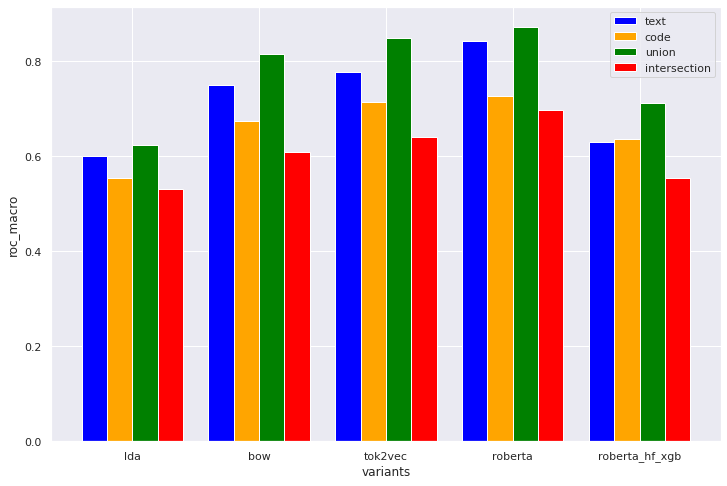

In [85]:
measure = 'roc_macro'
x = np.arange(5)
text = [results[x]['text'][measure] for x in variants]
code = [results[x]['code'][measure] for x in variants]
union = [results[x]['union'][measure] for x in variants]
intersection = [results[x]['intersection'][measure] for x in variants]
width = 0.2

# plot data in grouped manner of bar type
fig = plt.figure(figsize=(12,8))
plt.bar(x-0.3, text, width, color='blue')
plt.bar(x-0.1, code, width, color='orange')
plt.bar(x+0.1, union, width, color='green')
plt.bar(x+0.3, intersection, width, color='red')
plt.xticks(x, variants)
plt.xlabel("variants")
plt.ylabel(measure)
plt.legend(subvariants)
plt.show()


### Jaccard score samples average

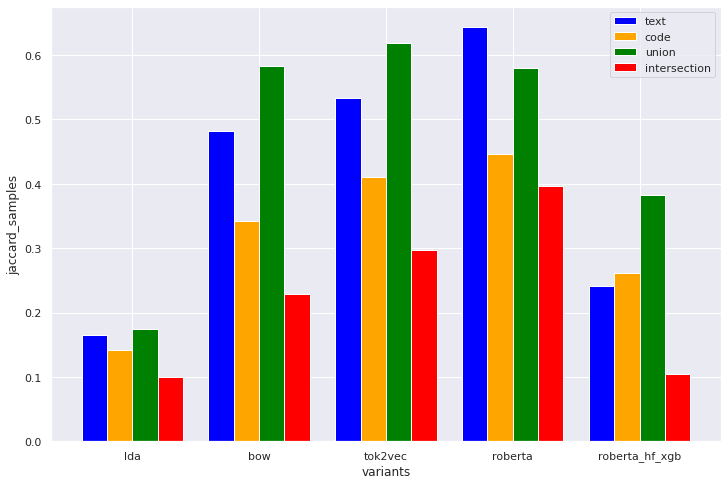

In [95]:
measure = 'jaccard_samples'
x = np.arange(5)
text = [results[x]['text'][measure] for x in variants]
code = [results[x]['code'][measure] for x in variants]
union = [results[x]['union'][measure] for x in variants]
intersection = [results[x]['intersection'][measure] for x in variants]
width = 0.2

# plot data in grouped manner of bar type
fig = plt.figure(figsize=(12, 8))
plt.bar(x-0.3, text, width, color='blue')
plt.bar(x-0.1, code, width, color='orange')
plt.bar(x+0.1, union, width, color='green')
plt.bar(x+0.3, intersection, width, color='red')
plt.xticks(x, variants)
plt.xlabel("variants")
plt.ylabel(measure)
plt.legend(subvariants)
plt.show()


### Recall samples average

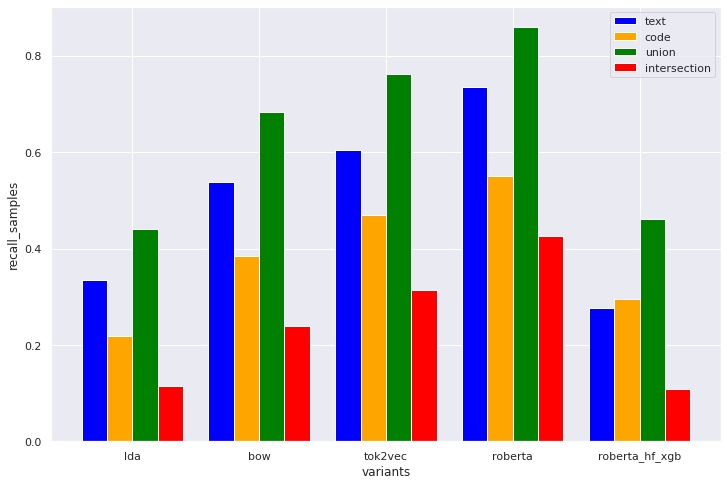

In [93]:
measure = 'recall_samples'
x = np.arange(5)
text = [results[x]['text'][measure] for x in variants]
code = [results[x]['code'][measure] for x in variants]
union = [results[x]['union'][measure] for x in variants]
intersection = [results[x]['intersection'][measure] for x in variants]
width = 0.2 

# plot data in grouped manner of bar type
fig = plt.figure(figsize=(12, 8))
plt.bar(x-0.3, text, width, color='blue')
plt.bar(x-0.1, code, width, color='orange')
plt.bar(x+0.1, union, width, color='green')
plt.bar(x+0.3, intersection, width, color='red')
plt.xticks(x, variants)
plt.xlabel("variants")
plt.ylabel(measure)
plt.legend(subvariants)
plt.show()


### Precision samples average

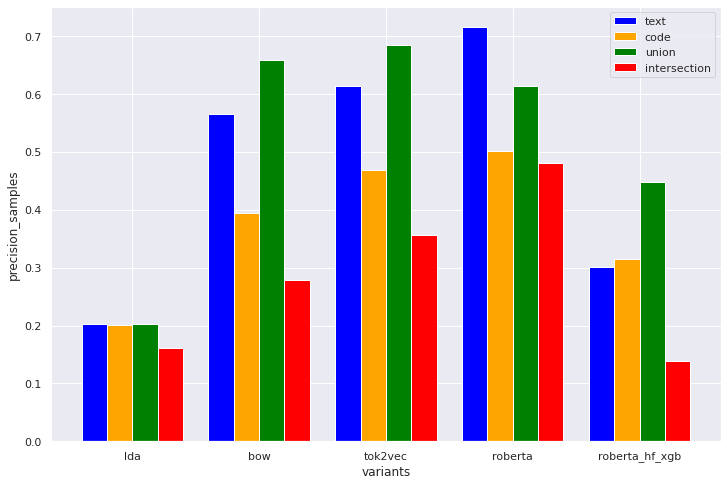

In [90]:
measure = 'precision_samples'
x = np.arange(5)
text = [results[x]['text'][measure] for x in variants]
code = [results[x]['code'][measure] for x in variants]
union = [results[x]['union'][measure] for x in variants]
intersection = [results[x]['intersection'][measure] for x in variants]
width = 0.2

# plot data in grouped manner of bar type
fig = plt.figure(figsize=(12, 8))
plt.bar(x-0.3, text, width, color='blue')
plt.bar(x-0.1, code, width, color='orange')
plt.bar(x+0.1, union, width, color='green')
plt.bar(x+0.3, intersection, width, color='red')
plt.xticks(x, variants)
plt.xlabel("variants")
plt.ylabel(measure)
plt.legend(subvariants)
plt.show()
